# Renewable Energy Systems (RES) project 
### Aarhus University - Fall 2020
#### Frederik Giessing Nielsen 201608565
This notebook includes the steps to optimize the capacity and dispatch of generators in the power system of one country.
For the project of the course Renewable Energy Systems (RES) you need to deliver a report including the sections described at the end of this notebook.

In [1]:
#Import packages and modules
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import mymodule as mm
plt.rcParams["figure.figsize"] = (15,5)

In [2]:
#Import data
df_elec = pd.read_csv('data_frederik/electricity_demand.csv', sep=';', index_col=0) # in MWh, only 2015
df_heat = pd.read_csv('data_frederik/heat_demand.csv', sep=';',index_col=0)
df_solar = pd.read_csv('data_frederik/pv_optimal.csv', sep=';', index_col=0)
df_onshorewind = pd.read_csv('data_frederik/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_inflow=pd.read_csv('data_frederik/Hydro_Inflow_CH.csv',sep=',') #2003-2012

In [3]:
#Create dictionary to map techs to colours
colors = {
    'demand': 'black',
    'onshorewind': 'purple',
    'solar': 'orange',
    'OCGT': 'brown',
    'ror':'blue',
    'hydrores':'cyan',
    'CHP':'red'
}

In this analysis Run of the river aswell as Hydroreosivoir electricity generation, will be included.

*Insert describtion of data find*

In [4]:
df_inflow=pd.read_csv('data_frederik/Hydro_Inflow_CH.csv',sep=',') #Read data
df_inflow.index=pd.to_datetime(df_inflow[['Year', 'Month', 'Day']]) #To date time index
df_inflow = df_inflow.groupby([df_inflow.index.month, df_inflow.index.day]).mean() #Reduce to days and with mean values
df_inflow=df_inflow.drop(columns=['Year','Month','Day']) #drop unessary columns
df_inflow=df_inflow.drop((2,29)) #drop skudår

days_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='D') #create datatimeindex with days
df_inflow.index=(days_in_2015) #make thid the new index
df_inflow=df_inflow.reindex(pd.date_range(start='2015-01-01T00:00Z', end='2015-12-31T23:00Z',freq='H'), method='ffill') #resample to hours
df_inflow=df_inflow/24*1000 #hours is just assumed 1/24 of daily values, converst to MWh.

df_ror=df_inflow.copy()/2
df_hydrores=df_ror.copy()

We start by creating the network. In this example, the country is modelled as a single node, so the network will only include one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case, Switzerland (CHE), and add one node (electricity bus) to the network.

In [5]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
network = pypsa.Network(override_component_attrs=override_component_attrs)
#network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H')
network.set_snapshots(hours_in_2015)

network.add("Bus","electricity bus")

In [6]:
# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['CHE'])

In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [7]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

The cost assumed for the generators are the same as in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf).

Add generators to the network, onshorewind, PV, aswell as run-of-river and gas turbine:

In [8]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "hydro inflow")

# add onshore wind generator

CF_wind = df_onshorewind['CHE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

# add solar PV generator

CF_solar = df_solar['CHE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)
###########
df_ror.index=CF_solar.index
df_hydrores.index=CF_solar.index
############
#add run-of-river generator
capital_cost_ror = annuity(80,0.07)*3000000*(1+0.02) # in €/MW
network.add("Generator",
            "ror",
            bus="electricity bus",
            p_nom=df_ror.max(),
            carrier="ror",
            p_max_pu = (df_ror/df_ror.max())["Inflow [GWh]"], #normalisation
            capital_cost = capital_cost_ror)
            

##add Hydro reservoir/hydro storage generator
# We assume 
capital_cost_hydrores = annuity(80,0.07)*2000000*(1+0.01) # in €/MW

network.add("StorageUnit",
            "hydrores",
            bus="electricity bus",
            p_nom_extendable=False,
            p_nom=8224, #https://www.bfe.admin.ch/bfe/en/home/supply/renewable-energy/hydropower/large-scale-hydropower.html
            max_hours=8.8*10**6/8224, #Capacity/nominal power #https://www.hydropower.org/blog/blog-hydropower-fundamental-for-sustainable-development-in-switzerland
            p_min_pu=0, #storing is not possiple, only dispatch
            carrier="hydrores",
            inflow=df_hydrores["Inflow [GWh]"],
            capital_cost = capital_cost_hydrores
            )            

We solve the linear optimal power flow (lopf) using Gurobi as solver.

In this case, we are optimising the installed capacity and dispatch of every generator to minimize the total system cost.

In [9]:
network.lopf(network.snapshots, 
             solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x70084_copy
  Lower bound: 1413690578.7072217
  Upper bound: 1413690578.7072217
  Number of objectives: 1
  Number of constraints: 78841
  Number of variables: 70084
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 70084
  Number of nonzeros: 179596
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

The total cost can be read from the network objetive.

In [10]:
print('Total cost of system is {:.2f} mio. € '.format(network.objective/1000000)) #in 10^6 €
print('Total cost of system pr. MWh is {:.2f} €'.format(network.objective/float(network.loads_t.p.sum()))) # €/MWh

Total cost of system is 1413.69 mio. € 
Total cost of system pr. MWh is 22.78 €


The optimal capacity for every generator can be shown.

In [11]:
network.generators.p_nom_opt # in MW

onshorewind        0.000000
solar          11549.043079
OCGT            5268.647083
ror             4465.341667
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator and the electricity demand, during the first week and a summer week of the year.


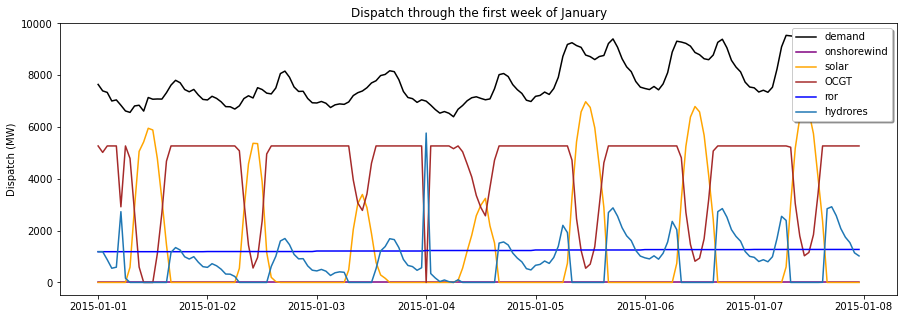

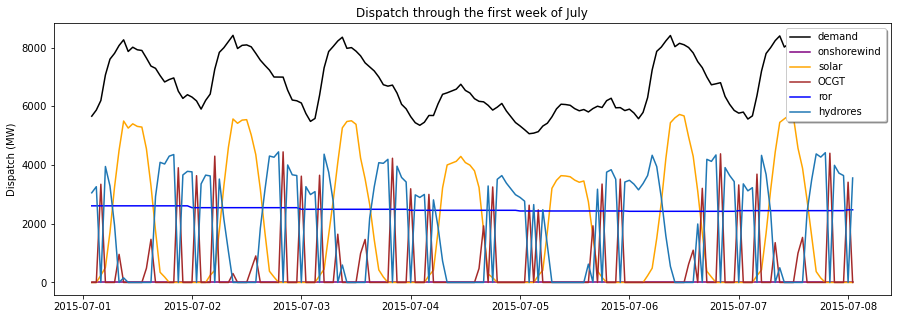

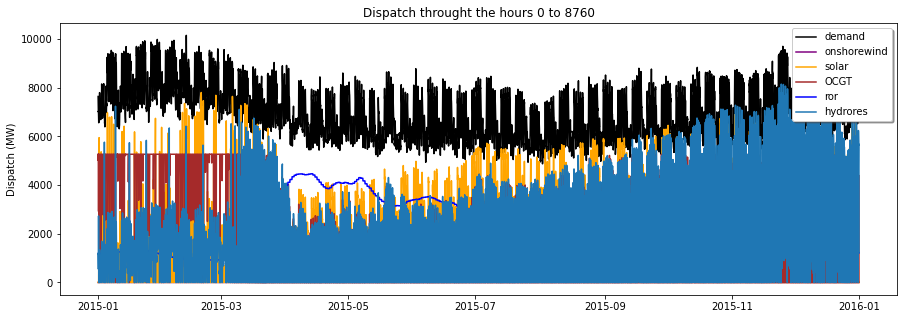

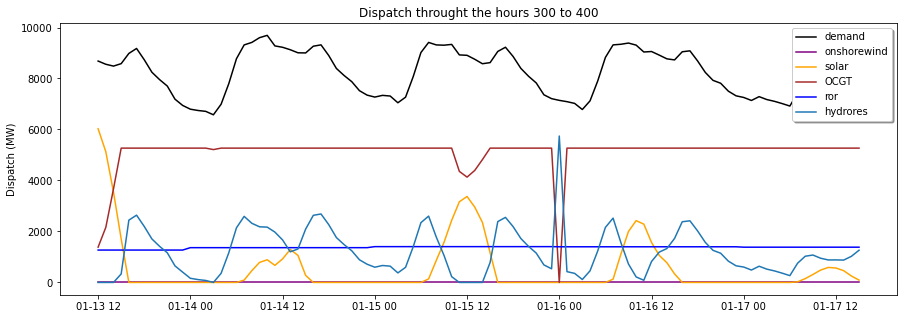

In [12]:
mm.plotdispatch(0,168,network,colors,title="Dispatch through the first week of January",dispstor=True)
mm.plotdispatch(4346,4346+168,network,colors,title="Dispatch through the first week of July",dispstor=True)
mm.plotdispatch(0,8760,network,colors,dispstor=True)
mm.plotdispatch(300,400,network,colors,dispstor=True)

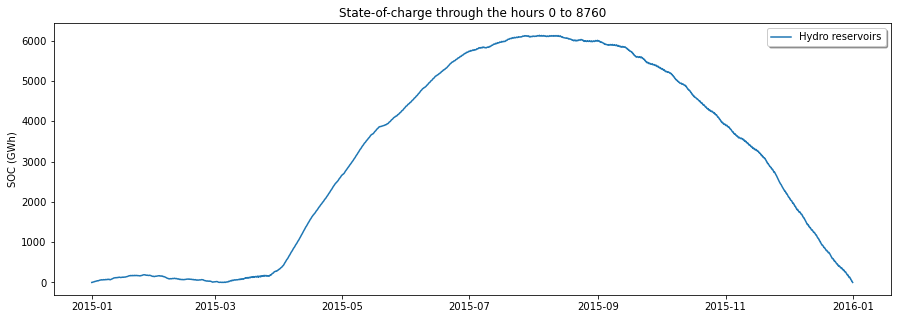

In [13]:
importlib.reload(mm)
mm.hydrosoc(0,8760,network,title="None")

We can also plot the electricity mix.

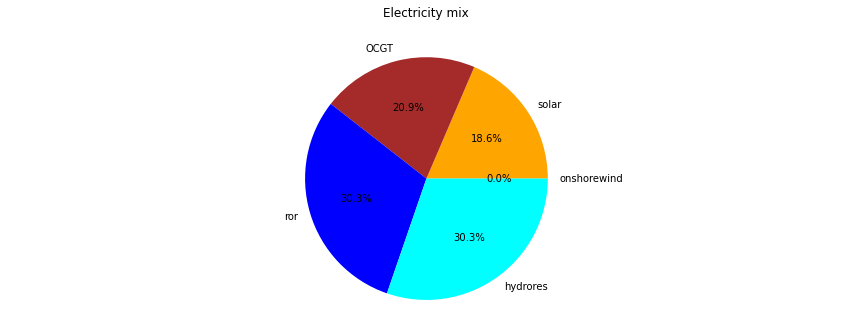

In [14]:
importlib.reload(mm)
mm.elecmix(network,colors)

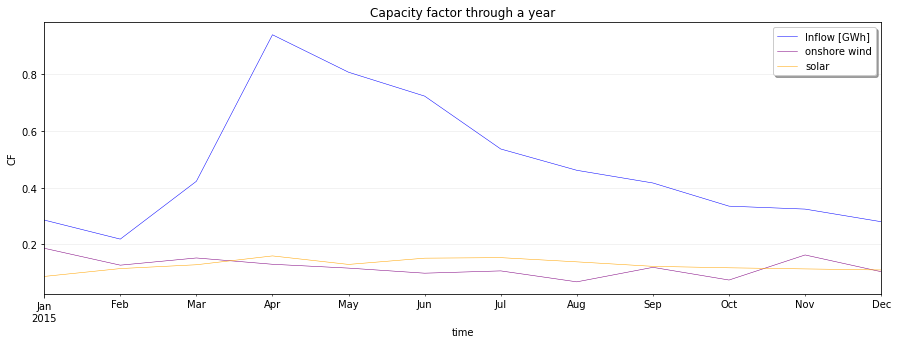

In [15]:
importlib.reload(mm)
mm.cfplot(CF_wind,CF_solar,df_ror,'M')

We can add a global CO2 constraint and solve again.

A. Choose a different country/region and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution from different technologies. 

In [16]:
co2_limit=500000 #tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

B. Investigate how sensitive is the optimum capacity mix to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer the emissions allowance to that historical data.

Lets add the historic CO2 values emitted by electricity generation.

*Source: https://www.iea.org/data-and-statistics?country=SWITLAND&fuel=CO2%20emissions&indicator=CO2EleBySource*

C. Investigate how sensitive are your results to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

In [17]:
#Set CO2 constrint
co2=250000
network.global_constraints.constant=co2

D. Add some storage technology/ies and investigate how they behave and what is their impact on the optimal system configuration.

In [18]:
#Add pumped hydro storage
#Assumptions: Power delivery is equal both ways, and max hours is propertional to nominal power
capital_cost_PHS = annuity(80,0.07)*2000000*(1+0.01) # in €/MW
network.add("StorageUnit",
            "PHS",
            bus="electricity bus",
            p_nom_extendable=False,
            p_nom=1380, #https://link.springer.com/article/10.1007/s40565-016-0239-y
            max_hours=369000/1380, #Capacity/nominal power
            #state_of_charge_initial=10000,
            carrier="PHS",
            efficiency_store=0.87,
            efficiency_dispatch=0.87,
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_PHS
            )

#Add battery storage
network.add("Bus","battery bus",carrier='DC')

capital_cost_battery = annuity(15,0.07)*144600*(1+0.00) # in €/MW
network.add("Store",
            "Battery",
            bus="battery bus",
            e_nom_extendable=True,
            capital_cost = capital_cost_battery
           )
#dispatch link - inverter
capital_cost_batterylink1 = annuity(20,0.07)*310000*(1+0.03) # in €/MW
network.add("Link",
            "batterylink1",
            bus0="battery bus",
            bus1="electricity bus",
            capital_cost=capital_cost_batterylink1,
            p_nom_extendable=True,
            efficiency=0.87
           )                    
#store link - inverter
capital_cost_batterylink2=annuity(20,0.07)*310000*(1+0.03) # in €/MW
network.add("Link",
            "batterylink2",
            bus1="battery bus",
            bus0="electricity bus",
            p_nom_extendable=True,
            capital_cost=capital_cost_batterylink2,
            efficiency=0.87
            )

#Add hydrogen storage
network.add("Bus","hydrogen bus",carrier='hydrogen')

capital_cost_hydrogen = annuity(20,0.07)*8400*(1+0.00) # in €/MW
network.add("Store",
            "Hydrogen",
            bus="hydrogen bus",
            e_nom_extendable=True,
            #e_initial=100000,
            capital_cost = capital_cost_hydrogen
           )
#dispatch link - fuel cell
capital_cost_hydrogenlink1 = annuity(20,0.07)*339000*(1+0.03) # in €/MW
network.add("Link",
            "hydrogenlink1",
            bus0="hydrogen bus",
            bus1="electricity bus",
            capital_cost=capital_cost_hydrogenlink1,
            p_nom_extendable=True,
            efficiency=0.58
           )                    
#store link - electrolysis
capital_cost_hydrogenlink2=annuity(18,0.07)*350000*(1+0.04) # in €/MW
network.add("Link",
            "hydrogenlink2",
            bus1="hydrogen bus",
            bus0="electricity bus",
            p_nom_extendable=True,
            capital_cost=capital_cost_hydrogenlink2,
            efficiency=0.8
            )

In [19]:
#Set CO2 constrint
co2=250000
network.global_constraints.constant=co2

E. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.) 

F. Select on target for decarbonizatio (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your result. 

G. Connect your country with, at least, two neighbour countries. You can assume that the capacities in the neighbours are fixed or cooptimize the whole system. You can also include fixed interconnection capacities or cooptimize them with the generators capacities. Discuss your results.

In [20]:
#Add country links
network.add("Bus","electricity bus DEU")
#network.add("Bus","Italy bus")
network.add("Bus","electricity bus FRA")
#network.add("Bus","Austria bus")

#Germany link
capital_cost_CHEDEU = annuity(40,0.07)*(400*602+150000)*(1+0.02)
network.add("Link",
            "CHE-DEU",
            bus0="electricity bus",
            bus1="electricity bus DEU",
            p_nom_extendable=True,
            efficiency=1,
            p_min_pu = -1, #this makes the link reversible
            length=602, # length (in km) between country a and country b
            capital_cost=capital_cost_CHEDEU # capital cost * length 
           )
#France link
capital_cost_CHEFRA = annuity(40,0.07)*(400*552+150000)*(1+0.02)
network.add("Link",
            "CHE-FRA",
            bus0="electricity bus",
            bus1="electricity bus FRA",
            p_nom_extendable=True,
            efficiency=1,
            p_min_pu = -1, #this makes the link reversible
            length=552, # length (in km) between country a and country b
            capital_cost=capital_cost_CHEFRA # capital cost * length 
           )
#FRA DEU LINK
capital_cost_DEUFRA = annuity(40,0.07)*(400*920+150000)*(1+0.02)
network.add("Link",
            "DEU-FRA",
            bus0="electricity bus DEU",
            bus1="electricity bus FRA",
            p_nom_extendable=True,
            efficiency=1,
            p_min_pu = -1, #this makes the link reversible
            length=920, # length (in km) between country a and country b
            capital_cost=capital_cost_DEUFRA # capital cost * length 
           )


In [21]:
#Run function that adds RE and OCGT generators
importlib.reload(mm);
mm.addcountry(network,'FRA',df_elec,df_onshorewind,df_solar,df_ror,df_hydrores)
mm.addcountry(network,'DEU',df_elec,df_onshorewind,df_solar,df_ror,df_hydrores)

In [22]:
#Run function that adds hydrogen and electric storage
importlib.reload(mm)
mm.addstor(network,'FRA')
mm.addstor(network,'DEU')

In [23]:
#Add new CO2 emissions
#https://www.iea.org/countries/france
co2=250000
CO2CHE1990=1*10**6
CO2FRA1990=38.6*10**6
CO2DEU1990=341.1*10**6
CO2new = CO2CHE1990*0.05+CO2DEU1990*0.05+CO2FRA1990*0.05

CO2new2 = co2*(1+((67+83)/8.57))#new co2 by scaling
CO2new3 = 200000
network.global_constraints.constant=CO2new

In [24]:
print(network.global_constraints.constant)
print(CO2new2)

co2_limit    19035000.0
Name: constant, dtype: float64
4625729.288214702


In [25]:
network.lopf(network.snapshots, 
             solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x385471_copy
  Lower bound: 61571471038.1279
  Upper bound: 61571471038.1279
  Number of objectives: 1
  Number of constraints: 692042
  Number of variables: 385471
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 385471
  Number of nonzeros: 1520198
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

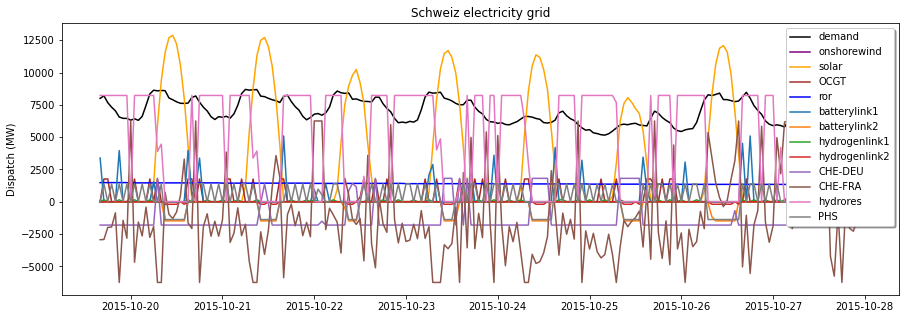

In [26]:
importlib.reload(mm);
mm.plotdispatch(7000,7200,network,colors,title="Schweiz electricity grid",dispstor=True)

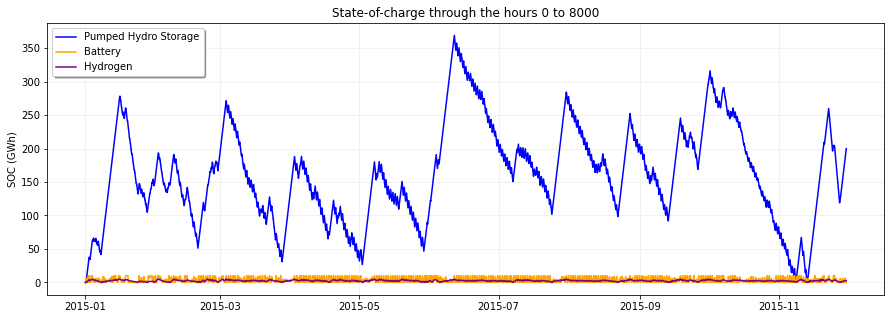

In [27]:
mm.plotsoc(0,8000,network)

In [28]:
print(network.generators.p_nom_opt)
print(network.storage_units.p_nom_opt)
print("Optimal electric battery capacity is {} MWh".format(network.stores.e_nom_opt.Battery))
print("Optimal hydrogen capacity is {} MWh".format(network.stores.e_nom_opt.Hydrogen))
print(network.links.p_nom_opt)

onshorewind             0.000000
solar               20339.952901
OCGT                 1758.610818
ror                  4465.341667
onshorewind FRA    345604.831441
solar FRA          163850.465968
OCGT FRA            34626.222281
onshorewind DEU     95314.494324
solar DEU           43167.194354
OCGT DEU            40220.140576
Name: p_nom_opt, dtype: float64
hydrores    8224.0
PHS         1380.0
Name: p_nom_opt, dtype: float64
Optimal electric battery capacity is 10176.255629101008 MWh
Optimal hydrogen capacity is 5129.186994467688 MWh
batterylink1          5088.127815
batterylink2          1703.903777
hydrogenlink1          149.930081
hydrogenlink2          246.595529
CHE-DEU               1807.658763
CHE-FRA               6248.841867
DEU-FRA              43998.856230
batterylink1 FRA      1981.389401
batterylink2 FRA       650.702595
hydrogenlink1 FRA    77970.701681
hydrogenlink2 FRA    65420.731554
batterylink1 DEU      3776.515330
batterylink2 DEU      1387.835692
hydrogenlink1 D

In [29]:
print('Total cost of system is {:.2f} mio. € '.format(network.objective/1000000)) #in 10^6 €
print('Total cost of system pr. MWh is {:.2f} €'.format(network.objective/network.loads_t.p.sum().sum())) # €/MWh
print("CO2 shadow price is: {} €/ton".format(network.global_constraints.mu.co2_limit)) #CO2 price Lagrance multiplier in the constraint)

Total cost of system is 61571.47 mio. € 
Total cost of system pr. MWh is 59.28 €
CO2 shadow price is: 272.1318798213438 €/ton


In [47]:
print(network.links_t.p0['CHE-FRA'].sum()/10**6)
print(network.links_t.p0['CHE-DEU'].sum()/10**6)
network.loads_t.p_set['load'].sum()/10**6

-9.279646159909074
6.281534366268433


62.060148

*H. Connect the electricity sector with another sector such as heating or transport, and cooptimize the two sectors. Discuss your results.*

In [19]:
network.add("Bus","heating bus",carrier="heat")
#network.add("Carrier", "heat")
#85% lives in city/towns so we assume centralised heating
#https://www.eda.admin.ch/aboutswitzerland/en/home/gesellschaft/bevoelkerung/stadt-und-land.html

# add load to the bus
network.add("Load",
            "heatload", 
            bus="heating bus", 
            p_set=df_heat['CHE']*0.85)

# Add Gas boiler (centralised assumed)
capital_cost_gasboiler = annuity(20,0.07)*63000*(1+0.015) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.9
marginal_cost_gasboiler = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "gasboiler",
            bus="heating bus",
            p_nom_extendable=True,
            carrier="gas",
            capital_cost = capital_cost_gasboiler,
            marginal_cost = marginal_cost_gasboiler)

# Add Resistive heater, as link
capital_cost_resistive = annuity(20,0.07)*100000*(1+0.02) # in €/MW
#marginal_cost_resistive = fuel_cost/efficiency # in €/MWh_el
network.add("Link",
            "resistive",
            bus0="electricity bus",
            bus1="heating bus",
            p_nom_extendable=True,
            efficiency=0.9,
            capital_cost=capital_cost_resistive)

# Add heatpump, as link
capital_cost_heatpump = annuity(20,0.07)*933000*(1+0.035) # in €/MW
#marginal_cost_resistive = fuel_cost/efficiency # in €/MWh_el
network.add("Link",
            "heat pump",
            bus0="electricity bus",
            bus1="heating bus",
            p_nom_extendable=True,
            efficiency=3, #efficiency/ COP assumed to be 3 bc schwitzerland is cold.
            capital_cost=capital_cost_heatpump)
#Add CHP, gas
network.add("Bus","CHP bus",carrier='CHP')
#https://www.sciencedirect.com/science/article/pii/S036054421831288X#bib96
capital_cost_CHP = annuity(20,0.07)*600000*(1+0.03) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
#efficiency = 0.87 # https://www.sciencedirect.com/science/article/pii/030142159390282K?via%3Dihub CHP catagorisation
network.add("Generator",
            "CHP",
            bus="CHP bus",
            p_nom_extendable=True,
            carrier="gas",
            capital_cost=capital_cost_CHP,
            marginal_cost=fuel_cost,
           )
#dispatch link 
network.add("Link",
            "CHPheatlink",
            bus0="CHP bus",
            bus1="heating bus",
            bus2="electricity bus",
            p_nom_extendable=True,
            efficiency=0.4,
            efficiency2=0.4,
           )
#dispatch link 
#network.add("Link",
#           "CHPeleclink",
#           bus0="CHP bus",
#           bus1="electricity bus",
#           p_nom_extendable=True,
#           efficiency=0.4
#          )

In [20]:
network.add("Bus","heating bus I",carrier="heat")
importlib.reload(mm)
mm.addiheat(network,df_heat)

Lets add some storage

In [21]:
importlib.reload(mm)
mm.addheatstor(network,'CHE')

I. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic.

In [22]:
network.add("Carrier", "nuclear")
capital_nuclear = 700*10**3 # USD/MW https://webstore.iea.org/download/direct/2779
capital_nuclear = 0.82*capital_nuclear #to euro
OEM=(170*10**3)*0.82 #OEM in euro/MW
OEM_pct=OEM/capital_nuclear
capital_cost_nuclear = annuity(10,0.07)*capital_nuclear*(1+OEM_pct) # in €/MW
network.add("Generator",
            "Nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_nuclear,
            marginal_cost = 8 
            )   

In [49]:
network.generators.p_nom_max['Nuclear']=20000
capital_cost_solar = annuity(25,0.07)*425000*0.5*(1+0.03) # in €/MW
network.generators.capital_cost['solar']=capital_cost_solar

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
network.lopf(network.snapshots, 
             solver_name='gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x315385_copy
  Lower bound: 2185056465.3626585
  Upper bound: 2185056465.3626585
  Number of objectives: 1
  Number of constraints: 560642
  Number of variables: 315385
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 315385
  Number of nonzeros: 1239551
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termin

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [52]:
print(network.generators.p_nom_opt)
print(network.storage_units.p_nom_opt)
print("Optimal electric battery capacity is {} MWh".format(network.stores.e_nom_opt.Battery))
print("Optimal hydrogen capacity is {} MWh".format(network.stores.e_nom_opt.Hydrogen))
print("Optimal ITES capacity is {} MWh".format(network.stores.e_nom_opt.ITES))
print("Optimal CTES capacity is {} MWh".format(network.stores.e_nom_opt.CTES))
print(network.links.p_nom_opt)

onshorewind        0.000000
solar           1994.952201
OCGT               0.000000
ror             4465.341667
gasboiler       6268.201010
CHP                0.000000
gasboiler I      730.262326
Nuclear        11010.975552
Name: p_nom_opt, dtype: float64
hydrores    8224.0
PHS         1380.0
Name: p_nom_opt, dtype: float64
Optimal electric battery capacity is 0.0 MWh
Optimal hydrogen capacity is 0.0 MWh
Optimal ITES capacity is 957.2104943335676 MWh
Optimal CTES capacity is 159074.20908438056 MWh
batterylink1        0.000000
batterylink2        0.000000
hydrogenlink1       0.000000
hydrogenlink2       0.000000
resistive           0.000000
heat pump        4712.349250
CHPheatlink         0.000000
resistive I       733.803014
heat pump I       766.016247
ITESlink1         930.987212
ITESlink2         746.412724
CTESlink1        8560.332480
CTESlink2        8654.320130
Name: p_nom_opt, dtype: float64


In [48]:
print("CO2 constraint: {} mio. ton".format(network.global_constraints.constant.co2_limit/10**6)) #CO2 limit (constant in the constraint)
print('Total cost of system is {:.2f} mio. € '.format(network.objective/1000000)) #in 10^6 €
print('Total cost of system pr. MWh is {:.2f} €'.format(network.objective/network.loads_t.p.sum().sum())) # €/MWh
print("CO2 shadow price is: {} €/ton".format(network.global_constraints.mu.co2_limit)) #CO2 price Lagrance multiplier in the constraint)

CO2 constraint: 0.25 mio. ton
Total cost of system is 7454.10 mio. € 
Total cost of system pr. MWh is 51.53 €
CO2 shadow price is: 2505.260609960978 €/ton


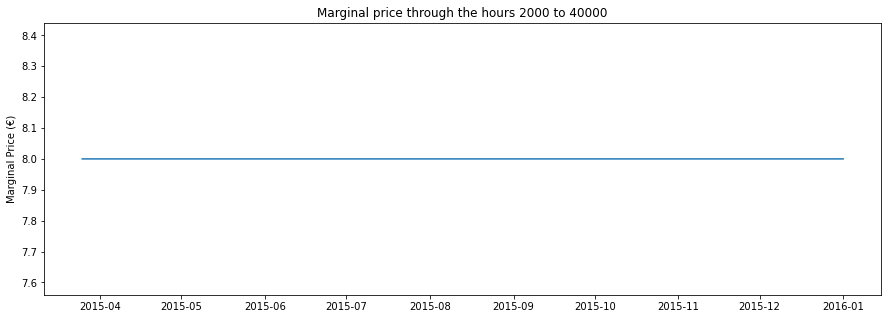

In [27]:
importlib.reload(mm)
mm.marginalprice(2000,40000,network)